## Importing Libraries & Data

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from wordcloud import WordCloud
from scipy.stats import pearsonr
import plotly.express as px

Mapping the category_id of each video to its category in the code below

Measuring engagement:

- engagement = likes + comments / views

This is an attempt to measure how engaging a video is. An assumption being made is that engaging videos will have more likes and comments per a certain number of views. This metric helps highlight videos that are engaging (having a lot of likes and comments), but have less views than a video with a lot of views, but very few comments and likes.

In [99]:
df = pd.read_csv('youtube_data.csv')


categories = pd.read_csv('youtube_categories.csv')

df = df.merge(categories, on = 'category_id', how = 'left')
df = df.drop_duplicates(subset = 'video_id')
df['published_at'] = pd.to_datetime(df['published_at'])
df['engagement'] = (df['like_count'] + df['comment_count']) / df['view_count']

df.to_csv('streamlit_data.csv', index = False)

In [100]:
df.dtypes

published_at      datetime64[ns]
video_id                  object
channel_id                object
title                     object
channel_title             object
view_count                 int64
like_count                 int64
comment_count              int64
tags                      object
duration                 float64
category_id                int64
timestamp                 object
category_title            object
engagement               float64
dtype: object

In [101]:
df['published_at'].min().strftime('%Y-%m-%d')

'2023-04-16'

In [102]:
df.head()

,published_at,video_id,channel_id,title,channel_title,view_count,like_count,comment_count,tags,duration,category_id,timestamp,category_title,engagement
0,2023-04-17 16:00:14,3inw26U-os4,UCKsN6xyJ2w8g7p4p9apXkYQ,Grupo Frontera x Bad Bunny - un x100to (Video ...,Grupo Frontera,18533453,978908,30640,"['bad bunny', 'grupo frontera', 'frontera', 'f...",3.250000,10,2023-04-19 10:53:26.617027,Music,0.054472
1,2023-04-18 21:10:35,yRCzziLUvYs,UCET00YnetHT7tOpu12v8jxg,Chelsea vs. Real Madrid: Extended Highlights |...,CBS Sports Golazo,803230,9056,1117,"['Champions League', 'Europa League', 'Soccer'...",11.750000,17,2023-04-19 10:53:26.617027,Sports,0.012665
2,2023-04-19 05:45:07,gUmE_TRdp0s,UCJ0uqCI0Vqr2Rrt1HseGirg,BLACKPINK Carpool Karaoke,The Late Late Show with James Corden,3456456,495906,18189,"['The Late Late Show', 'Late Late Show', 'Jame...",14.366667,24,2023-04-19 10:53:26.617027,Entertainment,0.148735
3,2023-04-18 15:00:30,QxS7KDYQBWs,UC071KjEQUoDUe3FvDU6j02Q,Freestyle with Love is Blind’s Marshall Glaze ...,Nick Viall,267261,6265,1348,"['nick viall', 'bachelor', 'abc', 'viall files...",92.783333,22,2023-04-19 10:53:26.617027,People & Blogs,0.028485
4,2023-04-18 04:30:35,koHXg0PlYq8,UC9-OpMMVoNP5o10_Iyq7Ndw,Draymond Ejected After STEPPING On Sabonis 😳,Bleacher Report,683683,3665,3691,"['bleacher report', 'br', 'nba', 'basketball',...",0.966667,17,2023-04-19 10:53:26.617027,Sports,0.010759


In [103]:
df.dtypes

published_at      datetime64[ns]
video_id                  object
channel_id                object
title                     object
channel_title             object
view_count                 int64
like_count                 int64
comment_count              int64
tags                      object
duration                 float64
category_id                int64
timestamp                 object
category_title            object
engagement               float64
dtype: object

Converting string representation of lists to lists

In [104]:
df['tags'] = df['tags'].apply(lambda x: eval(x))

## Measuring Video Engagment and Observing Its Trends

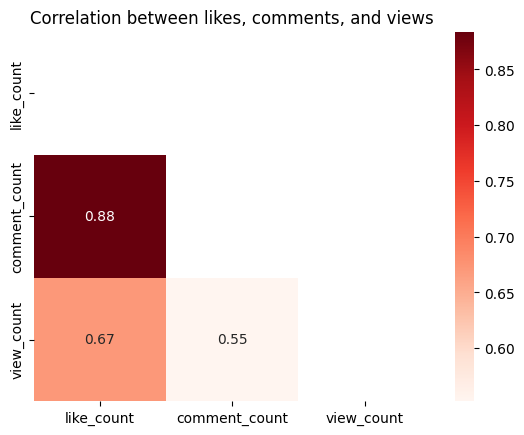

In [105]:
corr = df[['like_count', 'comment_count', 'view_count']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot = True, cmap = 'Reds', mask = mask);
plt.title('Correlation between likes, comments, and views');

As shown in the correlation heatmap, comments have a moderate, positive correlation with view count. Like count and view count have a moderately strong, positive correlation. Finally like count and comment count have a strong, positive correlation. Since these variables are all correlated, they will be used to create a new metric, engagement.

Video categories with the most engagment

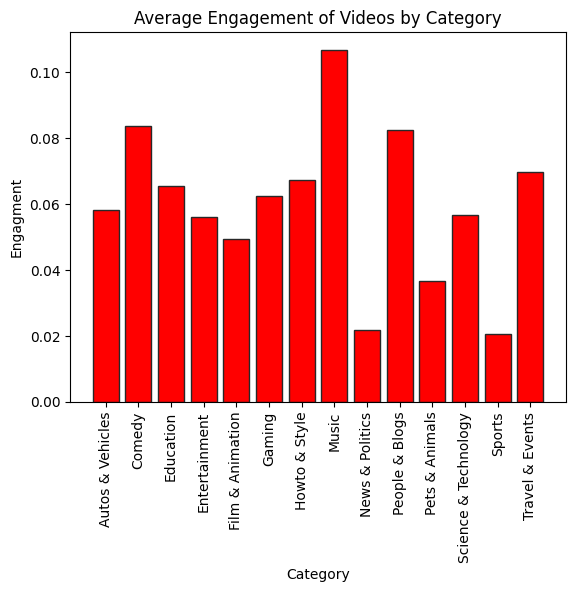

In [106]:
agg_cat = df.groupby('category_title')['engagement'].mean()
plt.bar(x = agg_cat.index, height = agg_cat, color = "#FF0000", edgecolor = '#282828');
plt.xticks(rotation=90);
plt.xlabel('Category');
plt.ylabel('Engagment');
plt.title('Average Engagement of Videos by Category');

It seems that videos under the category "Music" have the highest engagement

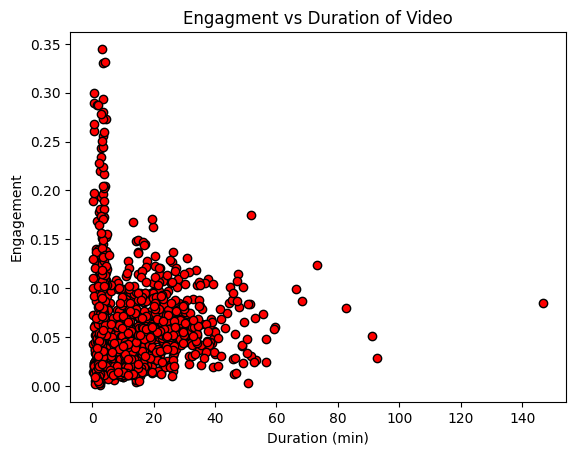

In [107]:
plt.scatter(x = df.duration, y = df.engagement, edgecolors = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Engagement');
plt.title('Engagment vs Duration of Video');

Looking at the scatterplot, it is possible that shorter videos tend to have a higher engagment on average, but a different visualization may help us make more accurate interpretations.

In [108]:
#removing outliers to bin data by duration appropriately
q1 = df.duration.quantile(0.25)
q3 = df.duration.quantile(0.75)
iqr = q3 - q1

lower_thresh = q1 - (1.5 * iqr)
upper_thresh = q3 + (1.5 * iqr)

is_not_outlier = (df['duration'] >= lower_thresh) & (df['duration'] <= upper_thresh)
df_no_outliers = df[is_not_outlier][['engagement', 'duration']].copy()

In [109]:
bins = list(range(0, 46, 5))
df_no_outliers['duration_bin'] = pd.cut(df_no_outliers['duration'], bins)
grouped_bins = df_no_outliers.groupby('duration_bin').mean().reset_index()

In [110]:
grouped_bins

,duration_bin,engagement,duration
0,"(0, 5]",0.077993,2.821126
1,"(5, 10]",0.035666,8.199310
2,"(10, 15]",0.049720,12.344413
3,"(15, 20]",0.060311,17.194398
4,"(20, 25]",0.062550,22.252257
5,"(25, 30]",0.064882,27.064524
6,"(30, 35]",0.065338,32.535417
7,"(35, 40]",0.056288,37.833333
8,"(40, 45]",0.063152,42.622222


In [111]:
x_ticks = grouped_bins['duration_bin'].apply(lambda x : x.right)


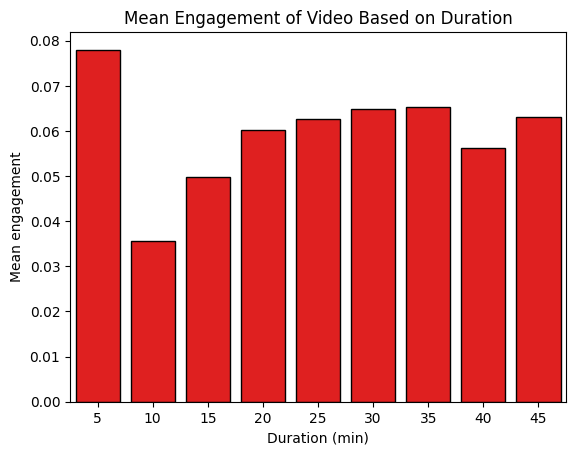

In [112]:
sns.barplot(x = x_ticks, y = grouped_bins.engagement, edgecolor = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Mean engagement');
plt.title('Mean Engagement of Video Based on Duration');

# DO LATER: Find a statistical test to see if shorter videos (0 - 5 minutes) have a significantly greater mean engagement compared to other duration videos 

## When is the best time to upload a video?

In [113]:
time_df = df[['published_at', 'view_count', 'like_count', 'comment_count', 'engagement']].copy()
time_df['published_at'] = pd.to_datetime(time_df['published_at'])

In [114]:
time_df_hour = time_df.groupby(time_df['published_at'].dt.hour).mean()

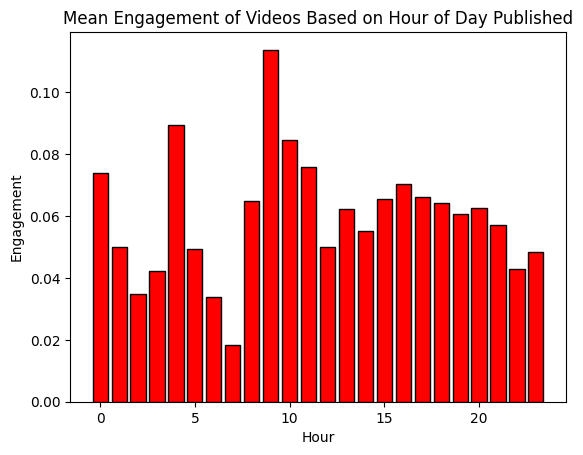

In [115]:
plt.bar(time_df_hour.index, time_df_hour['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

Hour 9 seems to be when the videos have the best average engagement

In [116]:
time_df_hour[time_df_hour['engagement'] == time_df_hour['engagement'].max()].index

Index([9], dtype='int32', name='published_at')

In [117]:
time_df_day = time_df.groupby(time_df['published_at'].dt.day_name()).mean()
time_df_day = time_df_day.reindex(list(pd.Series(pd.date_range('2023-01-01', periods=7)).dt.day_name()))

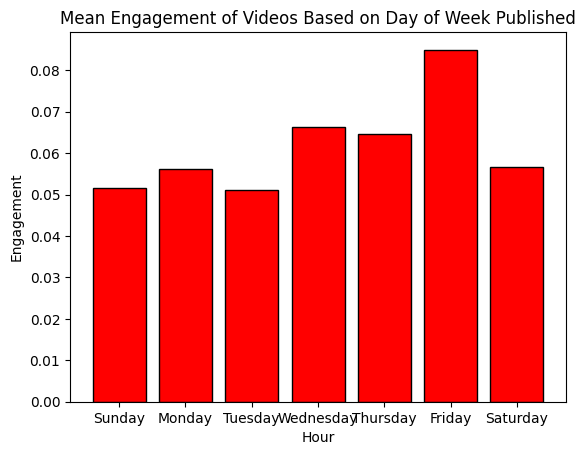

In [118]:
plt.bar(time_df_day.index, time_df_day['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Day of Week Published');

In [119]:
time_df_day

,published_at,view_count,like_count,comment_count,engagement
published_at,,,,,
Sunday,2023-05-16 10:15:48.823529472,1.016039e+06,42469.817647,3245.000000,0.051519
Monday,2023-05-20 18:09:04.825806336,1.487581e+06,79017.638710,5175.309677,0.056221
Tuesday,2023-05-17 10:58:19.146341376,1.377460e+06,49557.945122,3946.609756,0.051121
Wednesday,2023-05-11 05:56:51.868571392,9.314398e+05,49945.062857,3529.834286,0.066346
Thursday,2023-05-12 02:39:59.677852416,1.201231e+06,73460.859060,5478.355705,0.064655
Friday,2023-05-10 23:05:08.474025984,1.034445e+06,88821.889610,7490.272727,0.084934
Saturday,2023-05-14 03:38:57.354430208,1.026771e+06,45158.208861,3372.310127,0.056522


In [120]:
time_df_month = time_df.groupby(time_df['published_at'].dt.month.map({1: 'January', 2: 'February', 3: 'March', 4: 'April',
                                            5: 'May', 6: 'June', 7: 'July', 8: 'August',
                                            9: 'September', 10: 'October', 11: 'November', 12: 'December'})).mean()


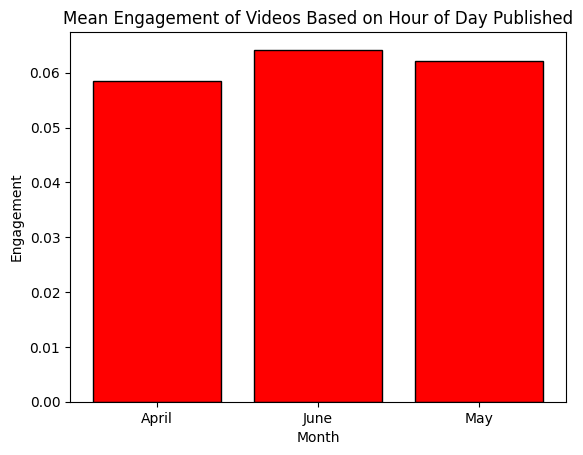

In [121]:
plt.bar(time_df_month.index, time_df_month['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Month');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

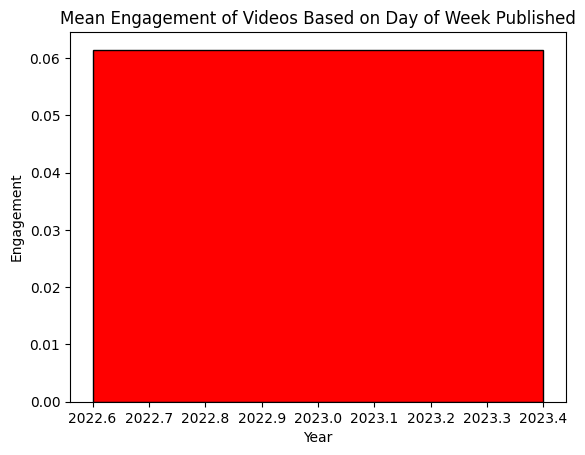

In [122]:
time_df_year = time_df.groupby(time_df['published_at'].dt.year).mean()
plt.bar(time_df_year.index, time_df_year['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Year');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Day of Week Published');


## Does the number of tags affect engagment?

## Most Popular Trending Categories

In [123]:
df.groupby(by = [df['published_at'].dt.day,'category_title'])['category_title'].count()

published_at  category_title  
1             Autos & Vehicles    2
              Comedy              1
              Entertainment       4
              Film & Animation    1
              Gaming              9
                                 ..
31            Gaming              5
              Music               6
              News & Politics     1
              People & Blogs      3
              Sports              2
Name: category_title, Length: 268, dtype: int64

In [124]:
df['category_title'].unique()

array(['Music', 'Sports', 'Entertainment', 'People & Blogs',
       'Science & Technology', 'Comedy', 'Film & Animation', 'Gaming',
       'Howto & Style', 'Education', 'News & Politics', 'Travel & Events',
       'Autos & Vehicles', 'Pets & Animals'], dtype=object)